# Disease Predictor

This notebook implements a Multi-Label Text Classification model using Bert Preprocessor and Bert Encoders. The model in question will predict the disease a certain individiual may have based on the symptoms that he/she enters in text form.

# Importing Libraries

We are importing the required libraries now for preprocessing our data, building our model and saving our prediction classes.

In [ ]:
# Install the compatible versions of TensorFlow Hub and TensorFlow Text
!pip install tensorflow-hub==0.16.0
!pip install tensorflow-text==2.9.0

  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.16.1
    Uninstalling tensorflow-hub-0.16.1:
      Successfully uninstalled tensorflow-hub-0.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 70.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstall

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import sklearn.preprocessing
import json
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow_text as text  # Registers the ops.


# Defining Hyperparameters

We are defining the number of epochs our model will train and the size of the batches our data will be split into.

In [ ]:
EPOCHS = 8
BATCH_SIZE = 64

# Importing & Cleaning our Data

We now import the csv file as a pandas DataFrame and then begin cleaning our data to prepare it for training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/S2D.csv'
df = pd.read_csv(file_path)
df.drop('Unnamed: 0', axis='columns', inplace=True)
df['label'] = df['label'].apply(lambda x: x.title())
df.head(2)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."


## One hot encoding the target labels

We now one hot encode the target labels since the labels are in string categorical format and so we convert it to one hot encoded format to make it suitable for training.

In [ ]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
df = df.join(pd.DataFrame(label_binarizer.fit_transform(df['label']),
                         columns=label_binarizer.classes_,
                         index=df.index
                         ))
df.drop('label', axis='columns', inplace=True)
df.head(2)

,text,Acne,Allergy,Arthritis,Bronchial Asthma,Cervical Spondylosis,Chicken Pox,Common Cold,Dengue,Diabetes,...,Impetigo,Jaundice,Malaria,Migraine,Peptic Ulcer Disease,Pneumonia,Psoriasis,Typhoid,Urinary Tract Infection,Varicose Veins
0,I have been experiencing a skin rash on my arm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"My skin has been peeling, especially on my kne...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Preparing Training & Validation Datasets

The next step is to split our DataFrames for training and testing and convert them to ```tf.data.Datasets()``` to apply batching and then caching and prefetching the data for faster training.

In [ ]:
classes = df.columns.tolist()  # Get the list of classes from your DataFrame

print(classes)

['text', 'Acne', 'Allergy', 'Arthritis', 'Bronchial Asthma', 'Cervical Spondylosis', 'Chicken Pox', 'Common Cold', 'Dengue', 'Diabetes', 'Dimorphic Hemorrhoids', 'Drug Reaction', 'Fungal Infection', 'Gastroesophageal Reflux Disease', 'Hypertension', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine', 'Peptic Ulcer Disease', 'Pneumonia', 'Psoriasis', 'Typhoid', 'Urinary Tract Infection', 'Varicose Veins']


In [ ]:
val_df = df.sample(frac=0.2)
train_df = df.drop(val_df.index)

print(f'Training Dataset Size: {len(train_df)}', f'Validation Dataset Size: {len(val_df)}', sep='\n')

Training Dataset Size: 960
Validation Dataset Size: 240


In [ ]:
def dataframe_to_tf_dataset(dataframe):
    dataframe = dataframe.copy()
    feature = dataframe.pop('text')
    ds = tf.data.Dataset.from_tensor_slices((feature, dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [ ]:
train_ds = dataframe_to_tf_dataset(train_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataframe_to_tf_dataset(val_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Building our Model

Now we move on to the main part, where we define the layers of the model.

## A description of our Model

We are building a keras Model using the functional API. The following is the description of the layers that we are using:

* We first create an Input Layer where we take the raw string as an input. The BERT preprocessor can handle raw strings from the dataset unlike the keras Embedding layer.
* The next step is to create a BERT preprocessor layer which would process our raw string and convert it to an useful form for the BERT encoders. The layer tokenizes our string and also uses Positional and Token Embeddings for extraction of context.
* The encoder is based on the Transformer architecture which then processes our encoded string and gives a pooled output.
* We then use a Dropout layer to prevent overfitting our model
* We then create another Dense Layer with 24 nodes representing our 24 classes with the softmax activation function as the output

In [ ]:

text_input = tf.keras.Input(shape=(), name='text', dtype='string')
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3", name='bert_preprocessor')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-6-h-128-a-2/versions/2" , trainable=True, name='bert_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output']
x = tf.keras.layers.Dropout(0.20, name='dropout')(pooled_output)
outputs = tf.keras.layers.Dense(24, activation='softmax', name='output')(x)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(24, activation='softmax')
])

# Reshape the output from the BERT model
x = tf.keras.layers.Reshape((1, 24))(outputs)
lstm_output = lstm_model(x)

model = tf.keras.Model(inputs=text_input, outputs=[outputs, lstm_output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


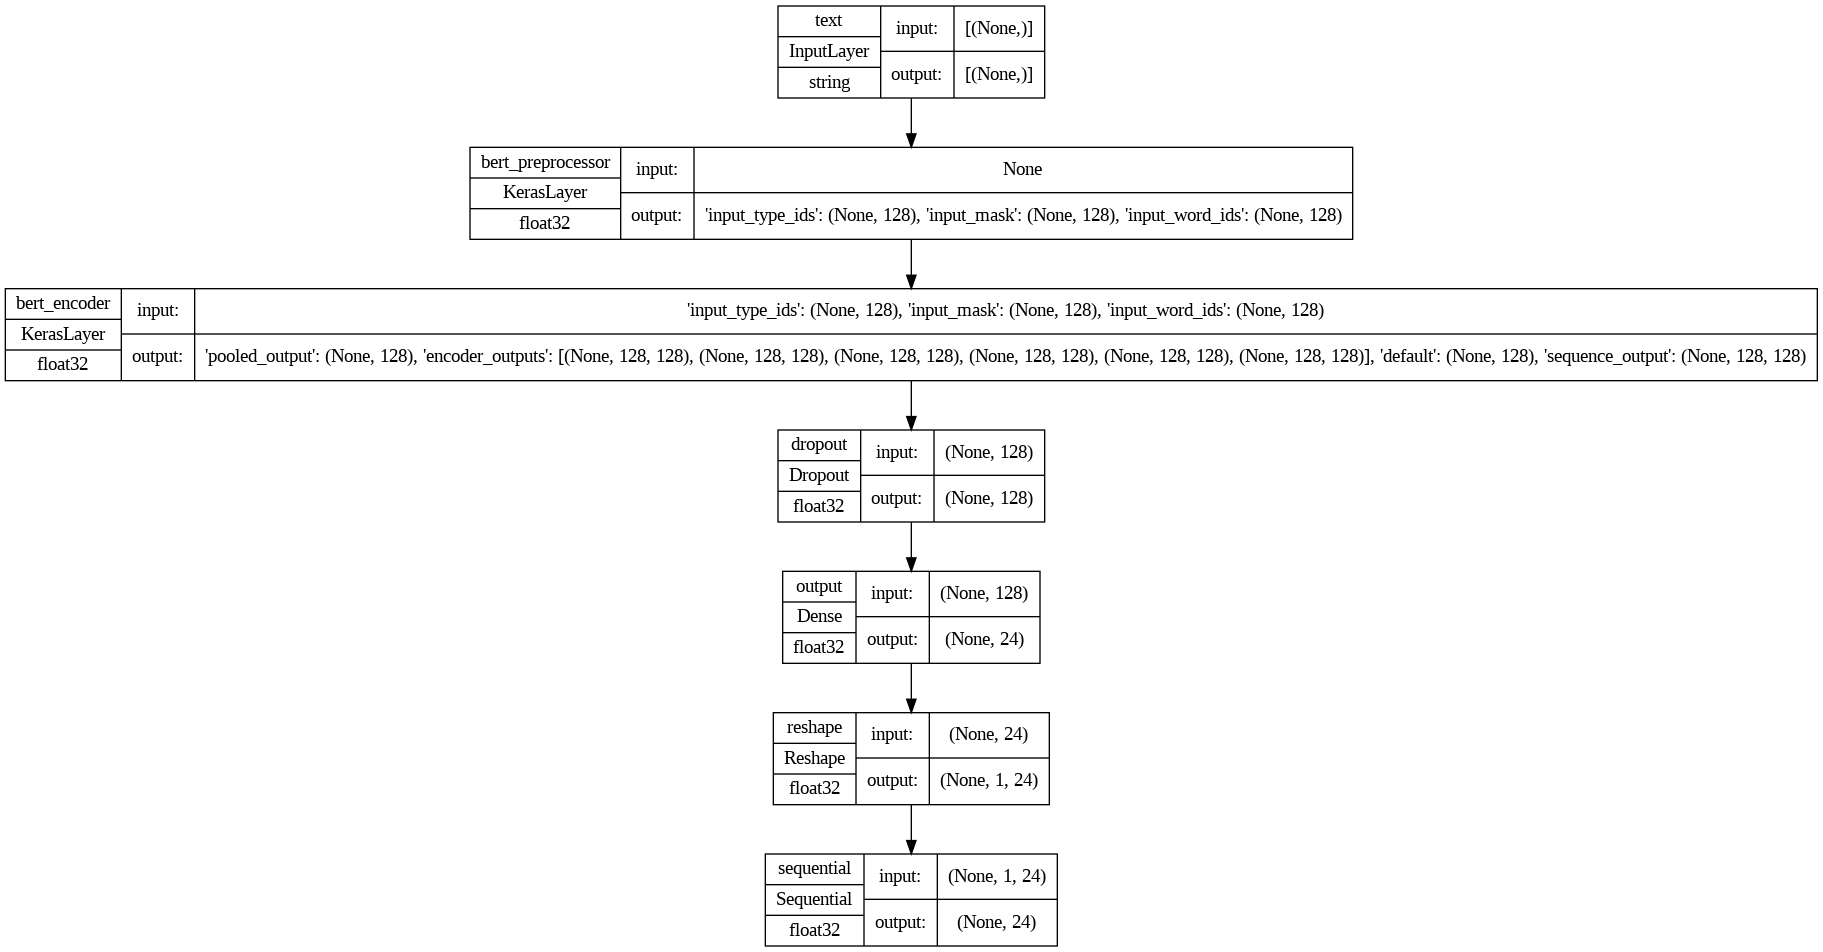

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/8
15/15 [==============================] - 45s 2s/step - loss: 6.5510 - output_loss: 3.3726 - sequential_loss: 3.1784 - output_accuracy: 0.0510 - sequential_accuracy: 0.0281 - val_loss: 6.1571 - val_output_loss: 2.9784 - val_sequential_loss: 3.1787 - val_output_accuracy: 0.1542 - val_sequential_accuracy: 0.0333
Epoch 2/8
15/15 [==============================] - 32s 2s/step - loss: 5.6069 - output_loss: 2.4298 - sequential_loss: 3.1771 - output_accuracy: 0.2844 - sequential_accuracy: 0.0510 - val_loss: 4.7104 - val_output_loss: 1.5340 - val_sequential_loss: 3.1764 - val_output_accuracy: 0.6333 - val_sequential_accuracy: 0.0958
Epoch 3/8
15/15 [==============================] - 33s 2s/step - loss: 4.4902 - output_loss: 1.3211 - sequential_loss: 3.1690 - output_accuracy: 0.6625 - sequential_accuracy: 0.1771 - val_loss: 4.0047 - val_output_loss: 0.8448 - val_sequential_loss: 3.1599 - val_output_accuracy: 0.7875 - val_sequential_accuracy: 0.4333
Epoch 4/8
15/15 [====================

# Testing our Model

We now test our model using some custom inputs to check its predictions.

## The predict function

The predict function here takes text as a parameter which is the string containing the user prompt. It then creates a dictionary with a key ```text``` and the value as the entered prompt. We then convert the entered prompt into a tensor so that our model can predict the class. We finally use the ```predict``` function of our model to predict the probability (the softmax function) of all our classes and we return the top three classes with the highest probability.

In [ ]:
import numpy as np
def predict(symptoms):
    feature = {'text': symptoms}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)
    classes = label_binarizer.classes_
    predictions_dict = {}
    for i in range(len(classes)):
        if np.argmax(predictions[0]) == i:
            predictions_dict[classes[i]] = np.max(predictions[0]) * 100
    sorted_predictions = sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True)
    predictions_dict = dict(sorted_predictions)
    count = 0
    for disease, prediction in predictions_dict.items():
        if count == 1:
            break
        print(f"Based on the symptoms provided, there exist a {prediction:.2f}% chance that you are suffering from {disease}\n")
        count += 1


In [ ]:
# prompt: i have a csv file named test stored in the same folder where symptoms2disease.csv is stored. when the disease is predicted, map the predicted disease under the column label to the corressponding test column named test in the csv file  named test and display the corressponding output based on the disease predicted . integrate it with the predict function

import pandas as pd
import numpy as np
def predict_with_test_results(symptoms):
    feature = {'text': symptoms}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)
    classes = label_binarizer.classes_
    predictions_dict = {}
    for i in range(len(classes)):
        if np.argmax(predictions[0]) == i:
            predictions_dict[classes[i]] = np.max(predictions[0]) * 100
    sorted_predictions = sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True)
    predictions_dict = dict(sorted_predictions)
    count = 0
    for disease, prediction in predictions_dict.items():
        if count == 1:
            break
        print(f"Based on the symptoms provided, there exist a {prediction:.2f}% chance that you are suffering from {disease}\n")
        count += 1

    return disease






In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
print(len(test_df))

9


In [ ]:
!pip install tabulate

In [ ]:
!pip install python-docx

import pandas as pd
import numpy as np
import datetime
import csv

from tabulate import tabulate
from docx import Document
from docx.enum.text import WD_BREAK


# Function to get patient's personal details
def get_personal_details():
    personal_details = {}
    '''print("Enter patient's personal details:")
    personal_details['Name'] = input("Name: ")
    personal_details["Father's Name"] = input("Father's Name: ")
    personal_details["Mother's Name"] = input("Mother's Name: ")
    personal_details['Address'] = input("Address: ")
    personal_details['Phone Number'] = input("Phone Number: ")
    personal_details['Email ID'] = input("Email ID: ")
    personal_details['Height'] = float(input("Height in cm: "))
    personal_details['Weight'] = float(input("Weight in kg: "))
    personal_details['Physical Activity Level'] = input("Physical Activity Level: ")
    personal_details['Body Temperature'] = float(input("Body Temperature in Celsius: "))
    personal_details['Blood Pressure'] = input("Blood Pressure: ")
    personal_details['Pulse Rate'] = int(input("Pulse Rate: "))
    personal_details['Allergies'] = input("Allergies: ")
    personal_details['Medications'] = input("Medications: ")
    personal_details['Occupation'] = input("Occupation: ")
    personal_details['Emergency Contact Name'] = input("Emergency Contact Name: ")
    personal_details['Emergency Contact Number'] = input("Emergency Contact Number: ")
    personal_details['Insurance Provider'] = input("Insurance Provider: ")
    personal_details['Insurance Policy Number'] = input("Insurance Policy Number: ")'''

    personal_details['Name'] = 'Albin'
    personal_details["Father's Name"] = 'Rony'
    personal_details["Mother's Name"] = 'Jeena'
    personal_details['Address'] = "No Address"
    personal_details['Phone Number'] = 989898989
    personal_details['Email ID'] = 'arm29292'
    personal_details['Height'] = 98
    personal_details['Weight'] = 99
    personal_details['Physical Activity Level'] = 'light'
    personal_details['Body Temperature'] = 35
    personal_details['Blood Pressure'] = 120/80
    personal_details['Pulse Rate'] = 100
    personal_details['Allergies'] = 'none'
    personal_details['Medications'] = 'none'
    personal_details['Occupation'] = 'student'
    personal_details['Emergency Contact Name'] = 'nill'
    personal_details['Emergency Contact Number'] = 'nill'
    personal_details['Insurance Provider'] = 'no'
    personal_details['Insurance Policy Number'] = 'no'

    return personal_details

# Function to get medical history and symptoms
def get_medical_history_symptoms():
    medical_history = []
    print("\nEnter patient's medical history:")
    while True:
        condition = input("Enter a medical condition (or 'done' to finish): ")
        if condition.lower() == 'done':
            break
        medical_history.append(condition)

    symptoms = input("\nEnter current symptoms: ")

    return medical_history, symptoms

# Function to generate case sheet for diagnosis
def generate_diagnosis_case_sheet(name, symptoms, disease, test_result, testdetails):
    case_sheet = [
        ['Patient Name', name],
        ['Symptoms', symptoms],
        ['Diagnosis', disease],
        ['Recommended Test', test_result],
        ['Test Report Details', testdetails]
    ]
    return case_sheet

# Function to write case sheet to file
def write_to_file(file_path, content):
    with open(file_path, 'w+') as file:
        st = "\t\t\t\t-----MEDICAL HISTORY-----\n\n"
        file.write(st)
        file.write(content)
        st = "\n\n\t\t\t\t-----END OF FILE-----"
        file.write(st)

# Get personal details from user
personal_details = get_personal_details()
personal_file_path = '/content/drive/MyDrive/Colab Notebooks/patient_details.txt'
with open(personal_file_path, 'w+') as file:
    st = "\t\t\t\t-----PERSONAL DETAILS-----\n\n"
    file.write(st)
    for key, value in personal_details.items():
        file.write(f"{key}: {value}\n")
    st = "\n\n\t\t\t\t-----END OF FILE-----"
    file.write(st)
print(f"File '{personal_file_path}' created successfully.")

# Get medical history and symptoms from user
medical_history, symptoms = get_medical_history_symptoms()
medical_file_path = '/content/drive/MyDrive/Colab Notebooks/medical_file.txt'
medical_content = "Medical History:\n"
for condition in medical_history:
    medical_content += f"- {condition}\n"
medical_content += "\nCurrent Symptoms:\n" + symptoms + "\n"
if 'Family Medical History' in personal_details:
    medical_content += "\nFamily Medical History:\n" + personal_details['Family Medical History']
write_to_file(medical_file_path, medical_content)
print(f"File '{medical_file_path}' created successfully.")

disease = predict_with_test_results(medical_content)
print(disease)

# MAPPING THE DISEASE TO THE TEST
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_result = test_data[test_data['label'] == disease]['test'].values[0]
print(f"The recommended test for {disease} is {test_result}")

# MAPPING THE TEST  to the ATTRIBUTES OF THE TEST
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test-details.csv')
testdetails = test_data[test_data['Test'] == test_result]['Findings'].values[0]
l = testdetails.split(', ')
lv = []
for x in l:
  m = input(x+': ')
  lv.append(m)
i = 0
st = 'TEST DETAILS: \n\n'
for i in range(len(l)):
  st += l[i] + ': ' + lv[i] + '\n'

# Generate diagnosis case sheet
diagnosis_case_sheet = generate_diagnosis_case_sheet(personal_details['Name'], symptoms, disease, test_result, testdetails)
diagnosis_file_path = '/content/drive/MyDrive/Colab Notebooks/diagnosis.txt'
with open(diagnosis_file_path, 'w+') as file:
    s = "\t\t\t\t-----DIAGNOSIS REPORT-----\n\n"
    file.write(s)
    for item in diagnosis_case_sheet:
        file.write(f"{item[0]}: {item[1]}\n")
    file.write(st)
    st = "\n\n\t\t\t\t-----END OF FILE-----"
    file.write(st)
print(f"File '{diagnosis_file_path}' created successfully.")

print("\nThank you for using our Medical Assistance Chatbot!")

File '/content/drive/MyDrive/Colab Notebooks/patient_details.txt' created successfully.

Enter patient's medical history:
Enter a medical condition (or 'done' to finish): done

Enter current symptoms: I keep sneezing, and I'm miserable and exhausted. I have a lot of gunky things in my nose and throat, and my throat is really hurting. My neck also feels puffy and swollen.
File '/content/drive/MyDrive/Colab Notebooks/medical_file.txt' created successfully.
Based on the symptoms provided, there exist a 99.15% chance that you are suffering from Common Cold

Common Cold
The recommended test for Common Cold is Complete Blood Count (CBC)
Hb: 123
Lymphocuytes: 234
Eosinophils: 345
Monocytes: 456
Basophils: 567
Platelets: 678
RBCs: 789
File '/content/drive/MyDrive/Colab Notebooks/diagnosis.txt' created successfully.

Thank you for using our Medical Assistance Chatbot!
